<a href="https://colab.research.google.com/github/ashishagg70/GANText2Image/blob/master/Text2FaceV6_BERT_CEloss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ! wget http://www.cs.toronto.edu/~rkiros/models/dictionary.txt
# ! wget http://www.cs.toronto.edu/~rkiros/models/utable.npy
# ! wget http://www.cs.toronto.edu/~rkiros/models/btable.npy
# ! wget http://www.cs.toronto.edu/~rkiros/models/uni_skip.npz
# ! wget http://www.cs.toronto.edu/~rkiros/models/uni_skip.npz.pkl
# ! wget http://www.cs.toronto.edu/~rkiros/models/bi_skip.npz
# ! wget http://www.cs.toronto.edu/~rkiros/models/bi_skip.npz.pkl

In [ ]:
!gdown --id 1D4yFM5bLF2PEVlM_yXzTp-cLjGgNai2m
#!gdown --id 1UQNd2OsbuuW5QSfc6-78e0heJk3F3FeL
#!gdown --id 14a90ceynctKczgase-iVbS8ZbwcTZSOT
#!gdown --id 1d1Cfsz1BcdWE_b4eF8KG6tSa0efsKLZ0
#!gdown --id 19DTv9tXIby7FW8TnU69u8xbNpcTWx6RG
!unzip img_align_celeba.zip
# !unzip list_attr_celeba.csv.zip
#!unzip list_bbox_celeba.csv.zip
#!unzip list_eval_partition.csv.zip
#!unzip list_landmarks_align_celeba.csv.zip

Streaming output truncated to the last 5000 lines.
 extracting: img_align_celeba/197600.jpg  
 extracting: img_align_celeba/197601.jpg  
 extracting: img_align_celeba/197602.jpg  
 extracting: img_align_celeba/197603.jpg  
 extracting: img_align_celeba/197604.jpg  
 extracting: img_align_celeba/197605.jpg  
 extracting: img_align_celeba/197606.jpg  
 extracting: img_align_celeba/197607.jpg  
 extracting: img_align_celeba/197608.jpg  
 extracting: img_align_celeba/197609.jpg  
 extracting: img_align_celeba/197610.jpg  
 extracting: img_align_celeba/197611.jpg  
 extracting: img_align_celeba/197612.jpg  
 extracting: img_align_celeba/197613.jpg  
 extracting: img_align_celeba/197614.jpg  
 extracting: img_align_celeba/197615.jpg  
 extracting: img_align_celeba/197616.jpg  
 extracting: img_align_celeba/197617.jpg  
 extracting: img_align_celeba/197618.jpg  
 extracting: img_align_celeba/197619.jpg  
 extracting: img_align_celeba/197620.jpg  
 extracting: img_align_celeba/197621.jpg  
 ex

In [ ]:
#!gdown --id 1VMBG_cAfbUZ7CJmzuQhkuPkSPBtkGOti #skipthoughts.py module for import ready python3.7
!gdown --id 1Z2nZ0sykKPn64BvzqrbwUjRFC4VqJAhm #annotated data Text2FaceAnnotation.json
#!gdown --id 1SYFQOQ1LSlGCgsr3QnzxCN-LDuUjEnYv #skip thought vectors of dim 4800 of descriptions
#!gdown --id 1KajlSVNK_UfPLnv5d-gNlwCSxcmkk4XO #filename in order of skip thought loaded

Downloading...
From: https://drive.google.com/uc?id=1Z2nZ0sykKPn64BvzqrbwUjRFC4VqJAhm
To: /content/Text2FaceAnnotation.json
100% 1.46M/1.46M [00:00<00:00, 101MB/s]


In [ ]:
import numpy as np
import torch
import sys
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import pandas as pd
from nltk.tokenize import word_tokenize
from torchvision import datasets, transforms
from PIL import Image
from torchvision.transforms import ToPILImage
import torchvision.utils as vutil
import json
from collections import defaultdict
#import skipthoughts
from importlib import reload 
import tqdm 
import os
#reload(skipthoughts)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

if device.type == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

cuda


In [ ]:
!pip install sentence-transformers

     |████████████████████████████████| 81kB 3.5MB/s 
     |████████████████████████████████| 2.1MB 8.1MB/s 
     |████████████████████████████████| 1.2MB 36.8MB/s 
     |████████████████████████████████| 901kB 40.7MB/s 
     |████████████████████████████████| 3.3MB 38.0MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-1.1.0-cp37-none-any.whl size=119615 sha256=920b1b5fd5e1eed48d66019720f92ab32e3d24a8fb18e8492902b67bef91b25f
  Stored in directory: /root/.cache/pip/wheels/84/cb/21/1066bff3027215c760ca14a198f698bca8fccb92e33e2327eb
Successfully built sentence-transformers


In [ ]:
from sentence_transformers import SentenceTransformer
#model = SentenceTransformer('bert-base-nli-mean-tokens')
model = SentenceTransformer('stsb-mpnet-base-v2')
#sentence_embeddings = model.encode(sentences) #give embedding of size 768

In [ ]:
sent1=['man','woman']
sent2=['black', 'brown']
sent1e=model.encode(sent1)
sent2e=model.encode(sent2)

In [ ]:
torch.nn.CosineSimilarity(dim=0, eps=1e-08)(torch.Tensor(sent2e[0]),torch.Tensor(sent2e[1]))

tensor(0.4545)

In [ ]:
json_filename='Text2FaceAnnotation.json'
file=open(json_filename,'r')
data=json.load(file)
data_dict={}
data_list_filename=[]
data_list_sentence=[]
for i,jsonElement in enumerate(data):
  data_dict[jsonElement['filename']]=jsonElement['description']
  data_list_filename.append(jsonElement['filename'])
  data_list_sentence.append(jsonElement['description'])
  #data_list.append((jsonElement['filename'],jsonElement['description']))

In [ ]:
# list_attr_celeba_test = pd.read_csv("list_attr_celeba.csv")
# #list_attr_celeba_test.head(10)
# attributes_test = list_attr_celeba_test.iloc[:,1:].values
# attributes_test[attributes_test<0]=0
# #attributes_test=np.tile(attributes_test,6)

In [ ]:
image_dir='./img_align_celeba/'
encoding_size = 768
compressed_encoding_size=256
z_features = 100
imagePixel=64
train_data_size=15000
std=0.5
mean=0.5
leakyRelu_slope = 0.2 #default = 0.1

In [ ]:
transform = transforms.Compose([transforms.Resize(imagePixel),
                                transforms.CenterCrop(imagePixel),
                                transforms.ToTensor(),transforms.Normalize(mean=[mean,mean,mean],
                          std=[std,std,std])])

In [ ]:
data_list_sentence_emb = model.encode(data_list_sentence)
data_list_sentence_emb.shape

(5685, 768)

In [ ]:
images_attr_data = []
i=0
for filename, description_bert_emb in zip(data_list_filename, data_list_sentence_emb):
  image = Image.open(image_dir+filename).convert('RGB')
  x = transform(image).numpy()
  i=i+1
  images_attr_data.append((x,description_bert_emb))

In [ ]:
def denorm(image):
    return (image*std)+mean

In [ ]:
train_loader = torch.utils.data.DataLoader(
    images_attr_data,
    batch_size=64,
    shuffle=True,
    # collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
    drop_last = True
)


In [ ]:
# def weights_init(m):
#     if type(m) == nn.Conv2d or type(m) == nn.ConvTranspose2d:
#         nn.init.normal_(m.weight.data, 0.0, 0.02)
#     elif type(m) == nn.BatchNorm2d:
#         nn.init.normal_(m.weight.data, 1.0, 0.02)
#         nn.init.constant_(m.bias.data, 0)
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [ ]:
class nn_G(nn.Module):
    def __init__(self):
      super().__init__()
      self.no_of_conv_layers=np.log2(imagePixel//8).astype('int32')
      dim = imagePixel*8

      self.conv=[]
      self.bnorm=[]
      self.compressLinear = nn.Linear(encoding_size,compressed_encoding_size)
      #self.conv_start = nn.ConvTranspose2d(compressed_encoding_size+z_features,dim,4,stride=1, padding=0, bias=False)
      #self.bnorm_start = nn.BatchNorm2d(dim)
      self.linearProjectionStart=nn.Linear(compressed_encoding_size+z_features,dim*4*4) #and reshaped to 512*4*4 in Text2FaceGAN paper 

      for i in range(self.no_of_conv_layers):
        self.conv.append(nn.ConvTranspose2d(dim,dim//2,4,stride=2, padding=1, bias=False))
        self.bnorm.append(nn.BatchNorm2d(dim//2))
        dim = dim//2
      self.conv=nn.ModuleList(self.conv)
      self.bnorm=nn.ModuleList(self.bnorm)
      assert dim == imagePixel
      self.conv_final = nn.ConvTranspose2d(dim,3,4,stride=2, padding=1, bias=False)   
    

    def forward(self,textEncoding):
      batch_size = textEncoding.shape[0]
      t = self.compressLinear(textEncoding)
      t = nn.LeakyReLU(leakyRelu_slope)(t)
      z = torch.randn(batch_size,z_features).to(device)
      x = torch.hstack((z,t))
      
      x = self.linearProjectionStart(x)
      x = x.view(-1, imagePixel*8, 4, 4)
      # x = x.unsqueeze(-1).unsqueeze(-1)
      # x = self.conv_start(x)
      # x = self.bnorm_start(x)
      # x = nn.LeakyReLU(leakyRelu_slope)(x)

      for i in range(self.no_of_conv_layers):
        x = self.conv[i](x)
        x = self.bnorm[i](x)
        x = nn.LeakyReLU(leakyRelu_slope)(x)
 
      x = self.conv_final(x)
      x = nn.Tanh()(x)

      return x


In [ ]:
nn_Gen = nn_G().to(device)
#nn_Gen.apply(weights_init)
print(nn_Gen)

nn_G(
  (compressLinear): Linear(in_features=768, out_features=256, bias=True)
  (linearProjectionStart): Linear(in_features=356, out_features=8192, bias=True)
  (conv): ModuleList(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (bnorm): ModuleList(
    (0): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_final): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
)


In [ ]:
class nn_D(nn.Module):
    def __init__(self):
      super().__init__()

      self.no_of_conv_layers=np.log2(imagePixel//4).astype('int32')
      in_channel=3
      out_channel=64
      dim = imagePixel*16
      self.conv=[]
      self.bnorm=[]

      for i in range(self.no_of_conv_layers):
        self.conv.append(nn.Conv2d(in_channel,out_channel,4,stride=2, padding=1, bias=False))
        self.bnorm.append(nn.BatchNorm2d(out_channel))
        in_channel = out_channel
        out_channel = out_channel*2
      #resulting 512*4*4
      self.conv=nn.ModuleList(self.conv)
      self.bnorm=nn.ModuleList(self.bnorm)

      #self.conv_t = nn.ConvTranspose2d(encoding_size,features,4,stride=1, padding=0, bias=False)
      #self.bnorm_t = nn.BatchNorm2d(features)

      self.compressLinear = nn.Linear(encoding_size,compressed_encoding_size)
      self.conv_final = nn.Conv2d(in_channel+compressed_encoding_size,1,4, bias = False)

    def forward(self,x,t):
      for i in range(self.no_of_conv_layers):
        x = self.conv[i](x)
        x = self.bnorm[i](x)
        x = nn.LeakyReLU(leakyRelu_slope)(x)

      t = self.compressLinear(t)
      t = nn.LeakyReLU(leakyRelu_slope)(t)
      t = t.view(-1, compressed_encoding_size, 1, 1).repeat(1, 1, 4, 4)

      x = torch.cat((x,t),dim=1)
      x = self.conv_final(x)

      #x=nn.Flatten()(x)
      x = nn.Sigmoid()(x)
      x=x.squeeze()

      return x


In [ ]:
nn_Dis = nn_D().to(device)
print(nn_Dis)

nn_D(
  (conv): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (bnorm): ModuleList(
    (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (compressLinear): Linear(in_features=768, out_features=256, bias=True)
  (conv_final): Conv2d(768, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
)


In [ ]:
# nn_Dis = torch.load('wgan_model_dis_V6')
# nn_Gen = torch.load('wgan_model_gen_V6')
# nn_Dis.train()
# nn_Gen.train()

In [ ]:

epochs = 200

learning_rate_dis = 0.0001
learning_rate_gen=0.0001*2
beta1=0.5
beta2=0.5
n_critic =5
flipRealAndFake=True
optimizer_gen = torch.optim.Adam(nn_Gen.parameters(),lr=learning_rate_gen,betas=(beta1,beta2))

optimizer_dis = torch.optim.Adam(nn_Dis.parameters(),lr=learning_rate_dis,betas=(beta1,beta2))

criterion = nn.BCELoss(reduction='mean')



In [ ]:
rm ./gen/*

In [ ]:
#!zip Bert_wloss_gen.zip gen/*

In [ ]:
i=0
for epoch in tqdm.notebook.tqdm(range(epochs)):
    for batch_idx, _data in enumerate(train_loader):
      _imgs, _attrs= _data
      _imgs = _imgs.to(device)
      _attrs = _attrs.to(device)
      if i < n_critic:
        optimizer_dis.zero_grad()
        out_real = nn_Dis(_imgs,_attrs)
        l = len(_attrs)
        real_labels = (1.3 - 0.7) * torch.rand((l,)) + 0.7
        real_tensor = torch.tensor(real_labels,dtype=torch.float).to(device)
        fake_labels = (0.3 - 0.0) * torch.rand((l,)) + 0.0
        fake_tensor = torch.tensor(fake_labels,dtype=torch.float).to(device)

        #print(out_real.shape)
        if(batch_idx%3!=0 or not flipRealAndFake):
            loss_real = criterion(out_real,real_tensor)
        else:
            loss_real = criterion(out_real,fake_tensor)

        out_fake = nn_Dis(nn_Gen(_attrs),_attrs)

        if(batch_idx%3!=0 or not flipRealAndFake):
            loss_fake = criterion(out_fake,fake_tensor)
        else:
            loss_fake = criterion(out_fake,real_tensor)

        loss_dis=loss_real + loss_fake
        loss_dis.backward()
        optimizer_dis.step()
        
        i+=1

      else:
        optimizer_gen.zero_grad()
        out_fake2 = nn_Dis(nn_Gen(_attrs),_attrs)
        loss_gen = criterion(out_fake2,real_tensor)
        loss_gen.backward()
        optimizer_gen.step()
        i=0
    with torch.no_grad():
        print("{}, out_real={},out_fake={},out_fake2={},loss_real={},loss_fake={},loss_gen={}".format(epoch, out_real.mean().item(),out_fake.mean().item(),out_fake2.mean().item(),loss_real.item(),loss_fake.item(),loss_gen.item()))
        os.makedirs('gen', exist_ok=True)
        gen_attr = torch.tensor(images_attr_data[100][1]).unsqueeze(dim=0).to(device)
        gen = denorm(nn_Gen(gen_attr))
        vutil.save_image(gen,'./gen/fixed-{}.jpg'.format(epoch))
        randomIndex=np.random.randint(0,len(images_attr_data))
        gen_attr_random = torch.tensor(images_attr_data[randomIndex][1]).unsqueeze(dim=0).to(device)
        gen2 = denorm(nn_Gen(gen_attr_random))
        vutil.save_image(gen2,'./gen/random-{}.jpg'.format(epoch))
    #img = ToPILImage()(gen.cpu())
    #img.save('./gen/{}.jpg'.format(epoch))



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


0, out_real=0.5848550796508789,out_fake=0.24881823360919952,out_fake2=0.4839782416820526,loss_real=0.8407123684883118,loss_fake=1.3880528211593628,loss_gen=0.7434983253479004
1, out_real=0.6911890506744385,out_fake=0.5237573385238647,out_fake2=0.4767689108848572,loss_real=1.0582354068756104,loss_fake=0.6528578996658325,loss_gen=0.7457025051116943
2, out_real=0.8434409499168396,out_fake=0.36878639459609985,out_fake2=0.34003880620002747,loss_real=0.11659843474626541,loss_fake=0.5450444221496582,loss_gen=1.1025943756103516
3, out_real=0.6292768120765686,out_fake=0.3579403758049011,out_fake2=0.42362725734710693,loss_real=0.9357669353485107,loss_fake=1.0270769596099854,loss_gen=0.8556018471717834
4, out_real=0.6759921312332153,out_fake=0.4915634095668793,out_fake2=0.48115336894989014,loss_real=1.0183831453323364,loss_fake=0.7107826471328735,loss_gen=0.7325114011764526
5, out_real=0.8537305593490601,out_fake=0.36028891801834106,out_fake2=0.32986313104629517,loss_real=0.19152095913887024,loss

In [ ]:
torch.save(nn_Dis, "bce_model_dis_V6_200epoch")
torch.save(nn_Gen, "bce_model_gen_V6_200epoch")

In [ ]:
sent_ind=3
data_list_sentence[sent_ind]

'An middle-aged woman with short blonde hair. Her eyebrows are darker than her hair colour. Her eyes are brown and there is some dark make-up around them. Her lips are thick and they are full. She is smiling with her lips parted and her upper teeth are visible.'

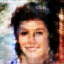

In [ ]:
gen_attr = torch.tensor(images_attr_data[sent_ind][1]).unsqueeze(dim=0).to(device)
gen = denorm(nn_Gen(gen_attr)).squeeze()
img = ToPILImage()(gen.cpu())
img

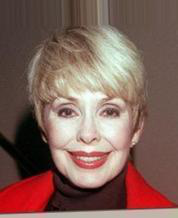

In [ ]:
filename='img_align_celeba/'+data_list_filename[sent_ind]
image = Image.open(filename)
image

In [ ]:
transform2 = transforms.Compose([transforms.Resize(64),
                                 transforms.CenterCrop(64),
                                transforms.ToTensor()])

In [ ]:
attributes_test[171]

In [ ]:
x = transforms.functional.to_tensor(image)
print(x.shape)
img = ToPILImage()(x.cpu())
img

In [ ]:
#pd.set_option("display.max_columns",None)
#print(list_attr_celeba.head(11))
list_attr_celeba.iloc[100]


References:\
1. https://www.kaggle.com/jessicali9530/celeba-dataset?select=list_attr_celeba.csv \
2. https://machinelearningmastery.com/how-to-implement-wasserstein-loss-for-generative-adversarial-networks/
3. https://towardsdatascience.com/getting-started-with-gans-using-pytorch-78e7c22a14a5
4. 

In [ ]:
while(1):
  pass

In [ ]:
!zip gen.zip gen/*

  adding: gen/fixed-0.jpg (deflated 4%)
  adding: gen/fixed-100.jpg (deflated 7%)
  adding: gen/fixed-101.jpg (deflated 7%)
  adding: gen/fixed-102.jpg (deflated 7%)
  adding: gen/fixed-103.jpg (deflated 7%)
  adding: gen/fixed-104.jpg (deflated 8%)
  adding: gen/fixed-105.jpg (deflated 7%)
  adding: gen/fixed-106.jpg (deflated 7%)
  adding: gen/fixed-107.jpg (deflated 7%)
  adding: gen/fixed-108.jpg (deflated 7%)
  adding: gen/fixed-109.jpg (deflated 7%)
  adding: gen/fixed-10.jpg (deflated 7%)
  adding: gen/fixed-110.jpg (deflated 7%)
  adding: gen/fixed-111.jpg (deflated 8%)
  adding: gen/fixed-112.jpg (deflated 7%)
  adding: gen/fixed-113.jpg (deflated 7%)
  adding: gen/fixed-114.jpg (deflated 7%)
  adding: gen/fixed-115.jpg (deflated 7%)
  adding: gen/fixed-116.jpg (deflated 7%)
  adding: gen/fixed-117.jpg (deflated 7%)
  adding: gen/fixed-118.jpg (deflated 7%)
  adding: gen/fixed-119.jpg (deflated 7%)
  adding: gen/fixed-11.jpg (deflated 8%)
  adding: gen/fixed-120.jpg (deflated 